In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/landcover_miniproject3/dataset

/content/drive/MyDrive/landcover_miniproject3/dataset


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [4]:
# Direktori dataset
train_dir = "/content/drive/MyDrive/landcover_miniproject3/dataset/train"
valid_dir = "/content/drive/MyDrive/landcover_miniproject3/dataset/valid"
test_dir = "/content/drive/MyDrive/landcover_miniproject3/dataset/test"

In [5]:
# Parameter preprocessing
IMG_SIZE = (256, 256)  # Resize ke 256x256
BATCH_SIZE = 16


In [6]:
# Mapping warna ke kelas
COLOR_MAP = {
    (96, 230, 99): 0,  # hutan_lahan_kering_primer
    (114, 255, 0): 1,  # hutan_lahan_kering_sekunder
    (229, 210, 152): 2,  # perkebunan
    (235, 192, 167): 3,  # semak_belukar
    (211, 229, 152): 4,  # hutan_tanaman
    (0, 0, 0): 5,  # pemukiman
    (214, 0, 115): 6,  # tanah_terbuka
    (212, 252, 247): 7,  # tubuh_air
    (255, 127, 127): 8,  # semak_belukar_rawa
    (246, 254, 167): 9,  # pertanian_lahan_kering
    (237, 245, 0): 10,  # pertanian_lahan_kering_campursemak
    (168, 214, 255): 11,  # sawah
    (202, 122, 245): 12,  # bandara/pelabuhan
    (114, 142, 167): 13,  # transmigrasi
    (167, 4, 0): 14  # pertambangan
}

In [7]:
def rgb_to_label(mask):
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for rgb, label in COLOR_MAP.items():
        mask_match = np.all(mask == np.array(rgb), axis=-1)
        label_mask[mask_match] = label
    return label_mask
# Fungsi untuk memuat gambar dan mask multi-kelas
def load_data(image_dir, mask_dir=None):
    images = []
    masks = [] if mask_dir else None

    for filename in os.listdir(image_dir):
        if "_sat.jpg" in filename:
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0  # Normalisasi
            images.append(img)

            if mask_dir:
                mask_filename = filename.replace("_sat.jpg", "_mask.jpg")
                mask_path = os.path.join(mask_dir, mask_filename)
                if os.path.exists(mask_path):
                    mask = load_img(mask_path, target_size=IMG_SIZE)
                    mask = img_to_array(mask).astype(np.uint8)
                    mask = rgb_to_label(mask)  # Konversi ke indeks kelas
                    masks.append(mask)

    images = np.array(images)
    masks = np.array(masks) if masks is not None else None
    if masks is not None:
        masks = masks[..., np.newaxis]  # Tambahkan dimensi channel

    return images, masks

In [8]:
# Load dataset
X_train, Y_train = load_data(train_dir, train_dir)
X_valid, Y_valid = load_data(valid_dir, valid_dir)
X_test, _ = load_data(test_dir)  # Tidak ada mask di test


In [9]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape

((123, 256, 256, 3),
 (123, 256, 256, 1),
 (35, 256, 256, 3),
 (35, 256, 256, 1),
 (18, 256, 256, 3))

In [10]:
#with skip connection
import tensorflow.keras as keras
from tensorflow.keras import layers

def unet_model(input_shape=(256, 256, 3), num_classes=7):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])  # Skip connection dari c2
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])  # Skip connection dari c1
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    model = keras.Model(inputs, outputs)
    return model



In [11]:
num_classes = 15
model = unet_model(num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 384)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,884,047 (7.19 MB)

 Trainable params: 1,884,047 (7.19 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Simpan model terbaik berdasarkan val_loss
checkpoint_callback = ModelCheckpoint(
    'model_best_unet_optimasi.h5',  # Nama file model yang disimpan
    monitor='val_loss',
    save_best_only=True,  # Hanya simpan jika lebih baik
    verbose=1
)

# # Hentikan training jika tidak ada peningkatan dalam 5 epoch
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,  # Jika dalam 10 epoch tidak membaik, stop training
#     restore_best_weights=True,  # Kembalikan bobot terbaik
#     verbose=1
# )

# Gunakan Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=16,  # Sesuaikan dengan RAM
    epochs=50,  # Bisa dikurangi kalau training lambat
    callbacks=[checkpoint_callback]  # Tambahkan callbacks
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5397 - loss: 1.7338   
Epoch 1: val_loss improved from inf to 0.57681, saving model to model_best_unet_optimasi.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.5526 - loss: 1.7027 - val_accuracy: 0.7901 - val_loss: 0.5768
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8322 - loss: 0.4622
Epoch 2: val_loss did not improve from 0.57681
8/8 ━━━━━━━━━━━━━━━━━━━━ 49s 538ms/step - accuracy: 0.8301 - loss: 0.4680 - val_accuracy: 0.7901 - val_loss: 0.5838
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8033 - loss: 0.5071
Epoch 3: val_loss improved from 0.57681 to 0.49220, saving model to model_best_unet_optimasi.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.8044 - loss: 0.5023 - val_accuracy: 0.7901 - val_loss: 0.4922
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8205 - loss: 0.3672
Epoch 4: val_loss improved from 0.49220 to 0.32445, saving model to model_best_unet_optimasi.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 0.8197 - loss: 0.3649 - val_accuracy: 0.7901 - val_loss: 0.3244
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8008 - loss: 0.2734
Epoch 5: val_loss improved from 0.32445 to 0.20303, saving model to model_best_unet_optimasi.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.8082 - loss: 0.2671 - val_accuracy: 0.9611 - val_loss: 0.2030
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9789 - loss: 0.0902
Epoch 6: val_loss did not improve from 0.20303
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.9786 - loss: 0.0909 - val_accuracy: 0.9612 - val_loss: 0.2333
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9820 - loss: 0.0763
Epoch 7: val_loss did not improve from 0.20303
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - accuracy: 0.9816 - loss: 0.0774 - val_accuracy: 0.9622 - val_loss: 0.2096
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9813 - loss: 0.0730
Epoch 8: val_loss improved from 0.20303 to 0.16979, saving model to model_best_unet_optimasi.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step - accuracy: 0.9810 - loss: 0.0736 - val_accuracy: 0.9619 - val_loss: 0.1698
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9824 - loss: 0.0634
Epoch 9: val_loss did not improve from 0.16979
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - accuracy: 0.9820 - loss: 0.0645 - val_accuracy: 0.9638 - val_loss: 0.1733
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9864 - loss: 0.0611
Epoch 10: val_loss improved from 0.16979 to 0.15489, saving model to model_best_unet_optimasi.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - accuracy: 0.9862 - loss: 0.0616 - val_accuracy: 0.9653 - val_loss: 0.1549
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9813 - loss: 0.0731
Epoch 11: val_loss did not improve from 0.15489
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - accuracy: 0.9817 - loss: 0.0716 - val_accuracy: 0.9651 - val_loss: 0.1761
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9827 - loss: 0.0694
Epoch 12: val_loss did not improve from 0.15489
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - accuracy: 0.9829 - loss: 0.0684 - val_accuracy: 0.9669 - val_loss: 0.1684
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9848 - loss: 0.0588
Epoch 13: val_loss did not improve from 0.15489
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - accuracy: 0.9848 - loss: 0.0588 - val_accuracy: 0.9689 - val_loss: 0.1557
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9855 - loss: 0.0584
Epoch 14: val_loss did not improve from 0.15489
8/8 ━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.9852 - loss: 0.0559 - val_accuracy: 0.9699 - val_loss: 0.1537
Epoch 22/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9844 - loss: 0.0577
Epoch 22: val_loss did not improve from 0.15368
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 501ms/step - accuracy: 0.9845 - loss: 0.0571 - val_accuracy: 0.9706 - val_loss: 0.1691
Epoch 23/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9850 - loss: 0.0556
Epoch 23: val_loss did not improve from 0.15368
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.9851 - loss: 0.0551 - val_accuracy: 0.9709 - val_loss: 0.1656
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9857 - loss: 0.0509
Epoch 24: val_loss did not improve from 0.15368
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.9857 - loss: 0.0508 - val_accuracy: 0.9693 - val_loss: 0.1589
Epoch 25/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9861 - loss: 0.0488
Epoch 25: val_loss did not improve from 0.15368
8/8 ━━━━

In [14]:
#simpan model
import os
save_path =  '/content/drive/MyDrive/landcover_miniproject3/model/unet/'
os.makedirs(save_path, exist_ok=True)
model.save(os.path.join(save_path, 'model_best_unet_100.h5'))

In [13]:
#simpan history training
import pickle
with open('/content/drive/MyDrive/landcover_miniproject3/model/unet/history_unet_50.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [17]:
#import model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/landcover_miniproject3/model/unet/model_best_unet_100.h5')

In [18]:
#import hisotry training
import pickle
with open('/content/drive/MyDrive/landcover_miniproject3/model/unet/history_unet_50.pkl', 'rb') as f:
    history_loaded = pickle.load(f)

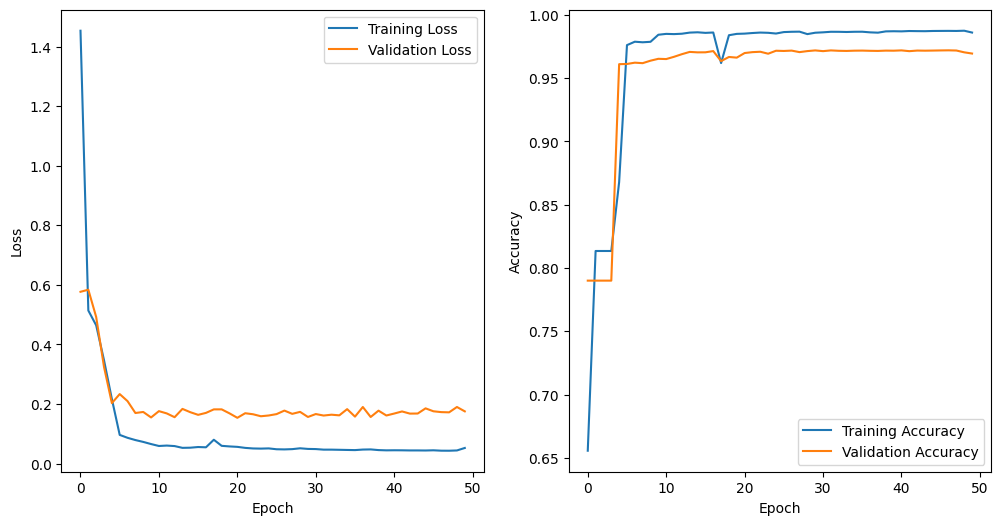

In [19]:

# Mengakses data dari history yang dimuat
train_loss = history_loaded['loss']
val_loss = history_loaded['val_loss']
train_accuracy = history_loaded['accuracy']
val_accuracy = history_loaded['val_accuracy']

#visualisasi data
import matplotlib.pyplot as plt

#plotting figure loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#plotting figure accuracy

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
